In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

data = pd.read_csv("C:\\Users\\murilo.pinheiro\\Documents\\Notebooks\\adult.csv")
data = data.drop('native-country', axis = 1)
data.info()
dataOther = data.loc[(data['race'] == 'Other')]
dataBlack = data.loc[(data['race'] == 'Black')]
data = data.drop(data.loc[data['race'] == 'Other'].index, axis = 0)
data = data.drop(data.loc[data['race'] == 'Black'].index, axis = 0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  income           48842 non-null  object
dtypes: int64(6), object(8)
memory usage: 5.2+ MB


In [26]:
x = data.drop(['income'], axis=1)
Y = data["income"]

xO = dataOther.drop(['income'], axis = 1)
yO = dataOther['income']

xB = dataBlack.drop(['income'], axis = 1)
yB = dataBlack['income']

from sklearn.model_selection import train_test_split

x_trainO, x_testO, Y_trainO, Y_testO = train_test_split(xO, yO, test_size = 0.3, random_state = 0)

x_trainB, x_testB, Y_trainB, Y_testB = train_test_split(xB, yB, test_size = 0.3, random_state = 5)

x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3, random_state = 3)

In [27]:
rus = RandomUnderSampler(random_state = 11, sampling_strategy = 0.3)
X_underO, y_underO = rus.fit_resample(x_trainO, Y_trainO)

rus = RandomUnderSampler(random_state = 0, sampling_strategy = 0.15)
X_underB, y_underB = rus.fit_resample(x_trainB, Y_trainB)

x_train = pd.concat([x_train, X_underO, X_underB])
Y_train = pd.concat([Y_train, y_underO, y_underB])

x_test = pd.concat([x_test, x_testO, x_testB])
Y_test = pd.concat([Y_test, Y_testO, Y_testB])

In [28]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

encoder2 = OrdinalEncoder(dtype = "int32")

num_x_testProtected = x_test.copy()
num_x_trainProtected = x_train.copy()

raceTest = num_x_testProtected["race"]
num_x_testProtected = num_x_testProtected.drop(["race"], axis = 1)
num_x_trainProtected = num_x_trainProtected.drop(["race"], axis = 1)

categoricalLabelsProtected = (num_x_testProtected.select_dtypes(include = ['object'])).columns

num_x_trainProtected[categoricalLabelsProtected] = encoder2.fit_transform(x_train[categoricalLabelsProtected])
num_x_testProtected[categoricalLabelsProtected] = encoder2.transform(x_test[categoricalLabelsProtected])
print(categoricalLabelsProtected)

num_Y_testProtected = Y_test.apply(lambda p: 1 if p == '>50K' else 0)
num_Y_trainProtected = Y_train.apply(lambda p: 1 if p == '>50K' else 0)


Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'gender'],
      dtype='object')


In [29]:
modeloProtected = DecisionTreeClassifier(random_state = 3)

modeloProtected.fit(num_x_trainProtected, num_Y_trainProtected)
previsaoProtected = modeloProtected.predict(num_x_testProtected)

acuraciaP = mean_absolute_error(num_Y_testProtected, previsaoProtected)
print(acuraciaP)

0.18732086802238296


In [30]:
newdata = pd.DataFrame()
newdata['race'] = raceTest.copy()
newdata['previsao'] = previsaoProtected.copy()
newdata['income'] = num_Y_testProtected.copy()

In [31]:
races = newdata['race'].unique()
tabela1 = pd.DataFrame(columns = ['Race', 'Valor'])

for race in races:
    groupedRaces = (newdata.loc[(newdata['race'] == race)])
    
    valor = mean_absolute_error(groupedRaces['income'], groupedRaces['previsao'])

    tabela1.loc[-1] = [race, valor]
    tabela1.index = tabela1.index + 1
    tabela1 = tabela1.sort_index()

tabela1['Valor'] = - (tabela1['Valor'] * 100) + 100 

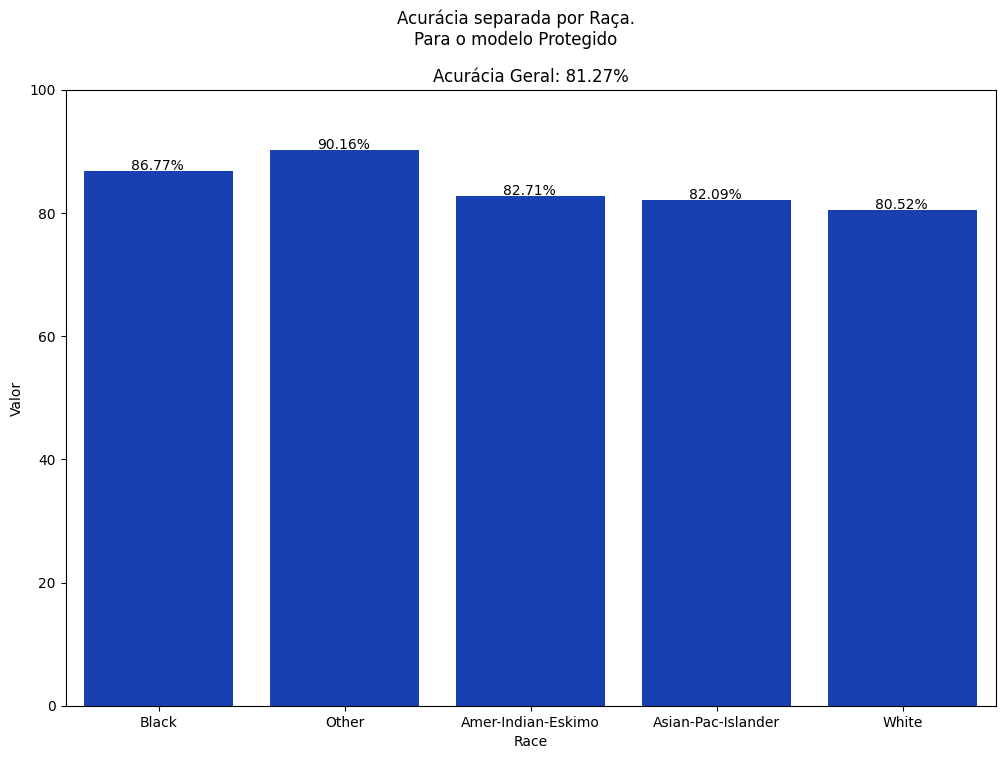

In [32]:
fig3 = plt.figure(figsize = (12, 8))
fig3.suptitle("Acurácia separada por Raça.\nPara o modelo Protegido")

# # plot = sns.barplot(ax2 = ax2[0], data = ,x = "proportion", y = "race", hue = "income")
# plot.set_ylabel("Raça")
# plot.set_xlabel("Proporção")

plot2 = sns.barplot(data = tabela1, x = "Race", y = "Valor", color = "#0033cc")

for index, row in tabela1.iterrows():
    plot2.text((row.name) - 0.15, (row.Valor) + 0.2, str(round(row.Valor, 2)) + "%",color='black')


plt.title("Acurácia Geral: " + str(round(-(acuraciaP * 100) + 100, 2)) + "%")
plt.ylim((0,100))
plt.show()
fig3.savefig("lastOutput.png")